In [1]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns 

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [20]:
role = 'Data Engineer'
df_US_DE = df[(df['job_title_short']==role)&(df['job_country']=='United States')].copy()
df_US_DE = df_US_DE.dropna(subset='salary_year_avg')
df_US_DE = df_US_DE.explode('job_skills')
df_US_DE[['job_skills','salary_year_avg']].head()

,job_skills,salary_year_avg
92,sql,120000.0
92,python,120000.0
146,golang,129500.0
146,scala,129500.0
146,python,129500.0


In [21]:
df_US_DE_skills = df_US_DE.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by='count', ascending=False)
df_US_DE_skills = df_US_DE_skills.rename(columns={'count': 'skill_count', 'median':'median_salary'}) 
df_US_DE_skills 

,skill_count,median_salary
job_skills,,
sql,2110,125000.00000
python,2007,127794.50000
aws,1313,131000.00000
spark,968,137410.15625
azure,961,125000.00000
...,...,...
next.js,1,145000.00000
nltk,1,130000.00000
cobol,1,125000.00000


In [ ]:
# Se calcula el total de trabajos y se divide por el count de los skills
df_US_DE_total = df[(df['job_title_short']==role)&(df['job_country']=='United States')].copy()
df_US_DE_total = df_US_DE_total.dropna(subset='salary_year_avg')
US_DE_job_count = len(df_US_DE_total)
df_US_DE_skills['skill_perc'] = 100*df_US_DE_skills['skill_count']/US_DE_job_count
df_US_DE_skills

,skill_count,median_salary,skill_perc
job_skills,,,
sql,2110,125000.00000,72.384220
python,2007,127794.50000,68.850772
aws,1313,131000.00000,45.042882
spark,968,137410.15625,33.207547
azure,961,125000.00000,32.967410
...,...,...,...
next.js,1,145000.00000,0.034305
nltk,1,130000.00000,0.034305
cobol,1,125000.00000,0.034305


In [29]:
skill_percent = 15

In [30]:
df_US_DE_skills_HD = df_US_DE_skills[df_US_DE_skills['skill_perc']>skill_percent]
df_US_DE_skills_HD

,skill_count,median_salary,skill_perc
job_skills,,,
sql,2110,125000.00000,72.384220
python,2007,127794.50000,68.850772
aws,1313,131000.00000,45.042882
spark,968,137410.15625,33.207547
azure,961,125000.00000,32.967410
snowflake,765,130700.00000,26.243568
java,732,137000.00000,25.111492
kafka,536,145000.00000,18.387650
nosql,519,140000.00000,17.804460


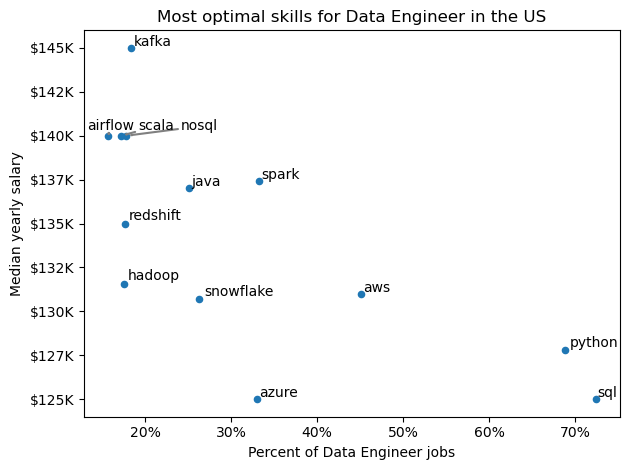

In [33]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter  

df_US_DE_skills_HD.plot(kind='scatter', x='skill_perc', y='median_salary')

texts = []
for i, txt in enumerate(df_US_DE_skills_HD.index):
    texts.append(plt.text(df_US_DE_skills_HD['skill_perc'].iloc[i], df_US_DE_skills_HD['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax =plt.gca()  
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.ylabel('Median yearly salary')
plt.xlabel(f'Percent of {role} jobs')
plt.title(f'Most optimal skills for {role} in the US')
plt.tight_layout()
plt.show()

Lo siguiente es opcional pero muy importante saberlo para la grafica


In [51]:
# Este codigo es para desenredar la columna de 'job_skill_type' que es un diccionario
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [52]:
# Se convierte el diccionario gigante en un DataFrame
df_technology_DF = pd.DataFrame(list(technology_dict.items()), columns=['technology','skills'])
df_technology_DF = df_technology_DF.explode('skills')
df_technology_DF

,technology,skills
0,analyst_tools,nuix
0,analyst_tools,msaccess
0,analyst_tools,cognos
0,analyst_tools,visio
0,analyst_tools,sas
...,...,...
9,sync,ringcentral
9,sync,wire
9,sync,zoom
9,sync,mattermost


In [54]:
# Usamos merge para unir los dos dataframes, el creado con los filtros y el creado por el diccionario
df_plot = df_US_DE_skills_HD.merge(df_technology_DF, left_on='job_skills', right_on='skills')
df_plot

,skill_count,median_salary,skill_perc,technology,skills
0,2110,125000.00000,72.384220,programming,sql
1,2007,127794.50000,68.850772,programming,python
2,1313,131000.00000,45.042882,cloud,aws
3,968,137410.15625,33.207547,libraries,spark
4,961,125000.00000,32.967410,cloud,azure
5,765,130700.00000,26.243568,cloud,snowflake
6,732,137000.00000,25.111492,programming,java
7,536,145000.00000,18.387650,libraries,kafka
8,519,140000.00000,17.804460,programming,nosql
9,514,135000.00000,17.632933,cloud,redshift


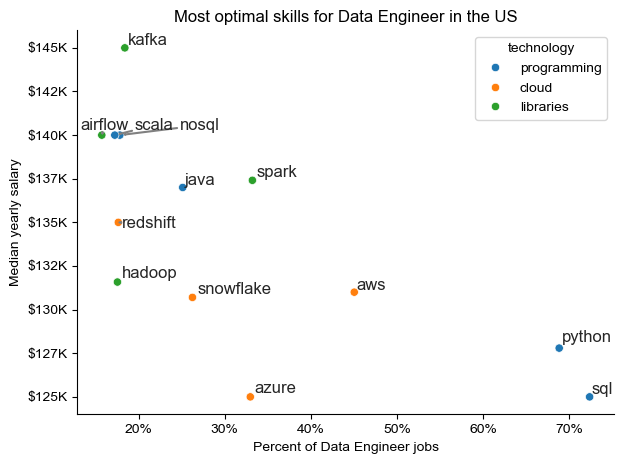

In [58]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter  

# df_plot.plot(kind='scatter', x='skill_perc', y='median_salary')
sns.scatterplot(df_plot, x='skill_perc', y='median_salary', hue='technology')
sns.despine()
sns.set_theme(style='ticks')

texts = []
for i, txt in enumerate(df_US_DE_skills_HD.index):
    texts.append(plt.text(df_US_DE_skills_HD['skill_perc'].iloc[i], df_US_DE_skills_HD['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax =plt.gca()  
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.ylabel('Median yearly salary')
plt.xlabel(f'Percent of {role} jobs')
plt.title(f'Most optimal skills for {role} in the US')
plt.tight_layout()
plt.show()